In [13]:
import pandas as pd
import pandas_ta as pta
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
import scripts.functions as fn 
from scripts.indicators import supertrend

C:\Users\lbisa\Mi unidad (leonardo.bisaro@gmail.com)\Cripto\python\InvestingEvolution\ie\www


Trading Supertrend (Intradia)
https://www.youtube.com/watch?v=xunl3G8uORw
Timeframe corto (5m) 

##Compra

- Señal de compra con "Pivot point supertrend"

- Precio cierre por encima de las MA

- EMA 50 > MA 200

- El volumen debe estar entre medio y alto

- Abrir posicion larga con SL apenas debajo de la EMA 50 y TP al doble del SL

In [14]:
klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/0m05/Lateral_BTCUSDT_0m05_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

#klines_file = './backtest/klines/1h04/Bajista_BTCUSDT_1h04_2021-04-12_2021-07-12.DataFrame'
with open(klines_file, 'rb') as file:
    df = pickle.load(file)
    #data.set_index('datetime',inplace=True)


#Volume Level

<Axes: >

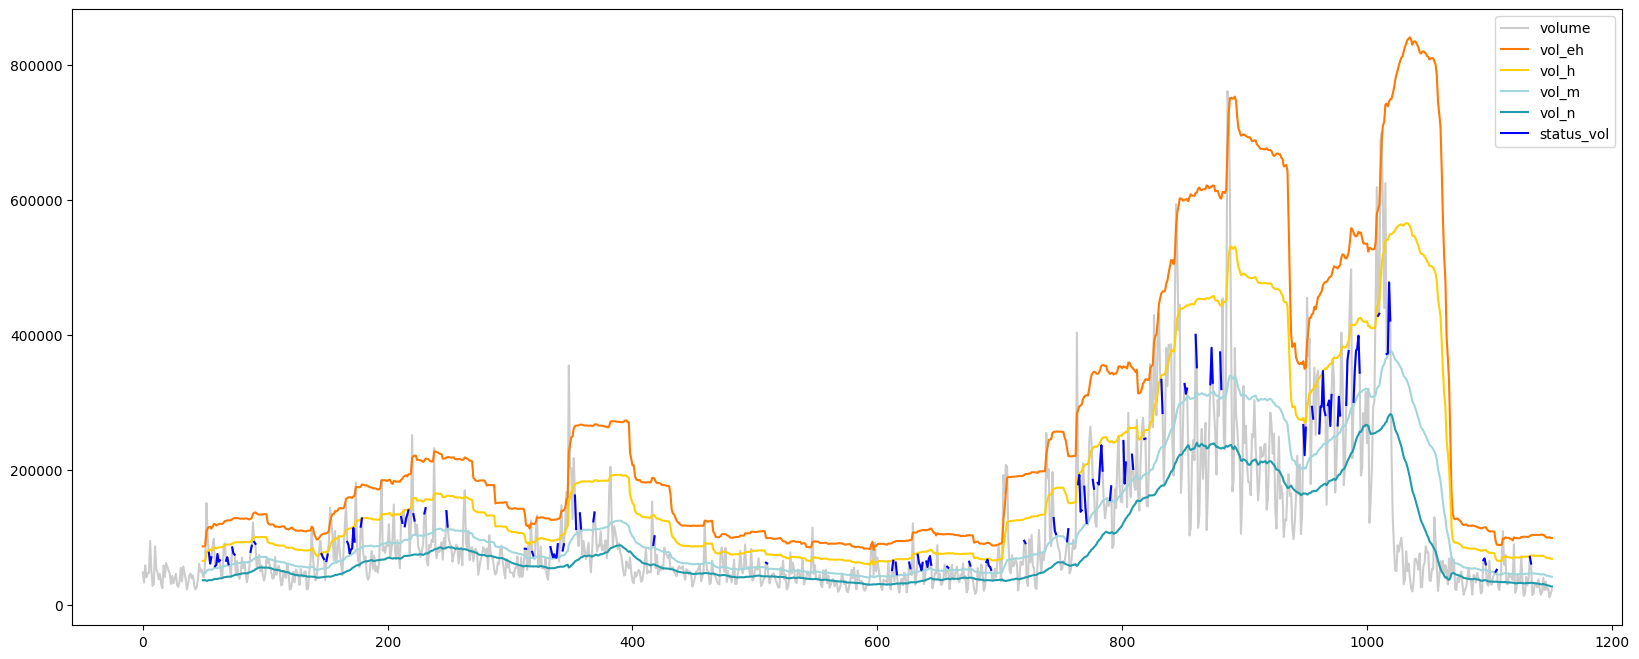

In [27]:
vol_period = 50
thresholdExtraHigh = 3
thresholdHigh = 1.5
thresholdMedium = 0.2
thresholdNormal = -0.5

df['vol_mean'] = df['volume'].rolling(window=vol_period).mean()
df['vol_std']  = df['volume'].rolling(window=vol_period).std()
df['vol_eh'] = df['vol_std'] * thresholdExtraHigh + df['vol_mean']
df['vol_h'] = df['vol_std'] * thresholdHigh + df['vol_mean']
df['vol_m'] = df['vol_std'] * thresholdMedium + df['vol_mean']
df['vol_n'] = df['vol_std'] * thresholdNormal + df['vol_mean']

#El volumen debe estar entre medio (vol_m) y alto (vol_h)
df['status_vol'] = np.where((df['volume']>df['vol_m']) & (df['volume']<df['vol_h']),df['volume'],None)

df[['volume','vol_h','vol_m','status_vol']].plot(figsize=(20,8),style=['#cccccc','#ffcf03','#a0d6dc','blue'])

#Medias moviles

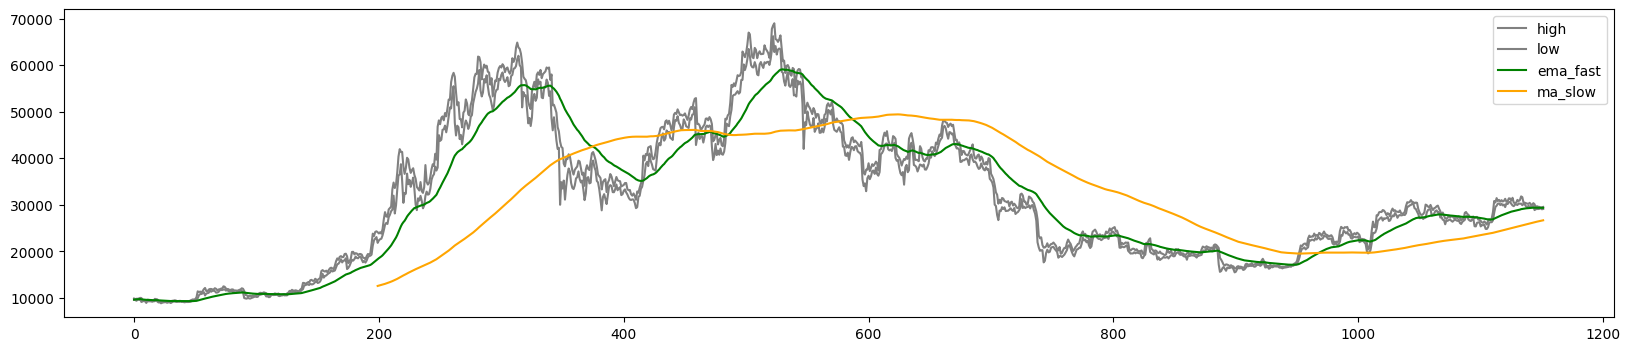

In [28]:
ema_period = 50
ma_period = 200
df['ema_fast'] = df['close'].ewm(span=ema_period).mean()
df['ma_slow']  = df['close'].rolling(window=ma_period).mean()

df[['high','low','ema_fast','ma_slow']].plot(figsize=(20,4),style=['gray','gray','green','orange'])

#El precio debe haber cerrado por encima de las MA y la EMA_fast debe ser mayor a la MA_slow
df['status_ma'] = np.where((df['ema_fast']>df['ma_slow'])&(df['close']>df['ema_fast']),1,0)

#Supertrend

In [29]:
df = supertrend(df,length=7,multiplier=3)


#Analisis de puntos de entrada

<Axes: >

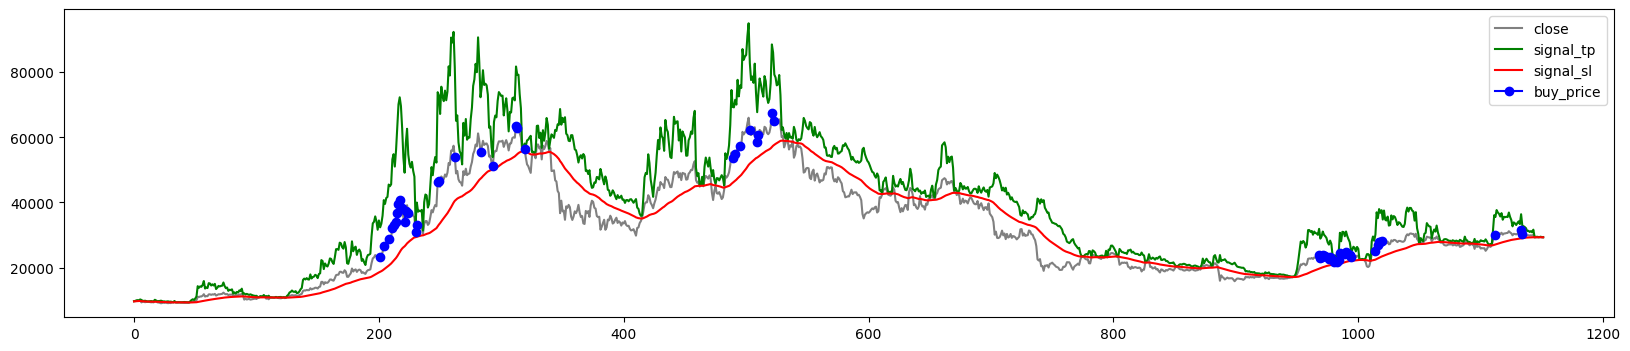

In [30]:
df['buy_price'] = np.where( (df['status_vol']>0) & (df['status_ma']>0) & (df['st_trend']>0) , df['close'] , None )

#Stop_loss apenas por debajo de la ema_fast
df['signal_sl'] = df['ema_fast']*( (1 - 0.002)  )
#Take profit = stop_loss% * 2
df['signal_tp'] = df['close'] * (1 + abs((df['signal_sl']/df['close'])-1) *2) 

df[['close','signal_tp','signal_sl','buy_price']].plot(figsize=(20,4),style=['gray','green','red','b-o'])
